## **JPEG ARTIFACT REMOVER**

Model is trained based on NoGan approach , initally both generator and discriminator is trained separately.After that , Normal Gan method is followed for both generator and discriminator.

<h4><b>Model Architecture</b></h4>

In this work, i followed the approach proposed in this paper ,

<b>A NoGAN approach for image and video
restoration and compression artifact removal</b>

<a href = "https://dl.acm.org/doi/10.1145/3394171.3414451">link</a>

I did lot of modifications as per my requirement, the intuition behind patchbased training,NoGan method is taken from the paper.

<ul>
  <li>Generator model will have single Residual in Residual Dense Block (RRDB) followed convolution layers</li>
  <li> Discriptor model will have 6 Convolution layer having leaky Relu as an activation function</li>
</ul>

<h4><b>Data Preparation</b></h4>

<ul>
  <h5><b>Generator Training</b></h5>
  <li>900 images is take from the <a href= "https://www.kaggle.com/datasets/joe1995/div2k-dataset">Div2k</a>dataset</li>
  <li> train_data = 700 , test_data = 100 , val_data = 100 </li>
  <li> Initially patches or cropping is done on the images by using albumentations library</li>
  <li> JPEG compression is done with a Quality Factor = 10 </li>

  <h5><b>Discriminator Training</b></h5>
  <li>Two input image is being passed, real high resolution image and reconstructed image from jpeg.</li>
  <li>train_data = 300 , test_data = 50 , val_data = 50</li>

  <h5><b>Gan Traning</b></h5>
  <li>Same data used for the generator is used</li>
</ul>

Here as of resource constraints,  batchsize = 1.


<h4><b>Losses</b></h4>
<ul>
  <li>Intially for the generator, there will be two losses, pixel loss (mse) and perceptual loss(VGG feature mse)</li>
  <li>For the Discriptor, Binary cross entropy is used</li>
  <li>During GanTraining, for generator ,in addition to above losses binary cross entroy is added as generator want the fake to be classified as real.
</ul>









<b>Referance:</b>

I took referance from the below papers and works,
<ul>
  <li>
    A NoGAN approach for image and video
restoration and compression artifact removal -> <a href="https://dl.acm.org/doi/10.1145/3394171.3414451">link</a>
  </li>
  <li>
  ESRGAN: Enhanced Super-Resolution
Generative Adversarial Networks <a href= "https://arxiv.org/abs/1809.00219">link</a>
  </li>
  <li>
   Implementation of ESRGAN <a href="https://github.com/peteryuX/esrgan-tf2">link</a>
  </li>
</ul>


# Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing  dependencies

In [3]:
# file handling
import os
import shutil


import numpy as np
import yaml
import random

# visualization and augmentation
import albumentations as A
from PIL import Image
from matplotlib import pyplot as plt

# tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.layers import(
    Input,
    Conv2D,
    Conv2DTranspose,
    Add,
    Concatenate,
    LeakyReLU,
    Dense,
)
from tensorflow.keras.preprocessing.image import save_img

In [4]:
# changing the rootdirectory
os.chdir("/content/drive/MyDrive/jpegartifact")

## Data Preparation

In this section we are,

<ul>
 <li> Downloading the dataset</li>
 <li> Making the proper directory structure for the data</li>
 <li> Augmenting  and randomly cropping the images </li>
 <li> Converting the high quality images to jpeg compressed images</li>
</ul>

In [5]:
#configuration and paths are saved in yaml file
with open('config.yaml', 'r') as stream:
        config = yaml.safe_load(stream)

In [ ]:

# if you didnt download the dataset, follow the  below steps
# link to the DIV2K Dataset : https://www.kaggle.com/datasets/joe1995/div2k-dataset/download?datasetVersionNumber=1
# download the dataset to the current working directory , it will be saved as archive.zip
# unzip the archive.zip
# move the all the images to ./data/reference

!unzip archive.zip -d ./data/
train_src = "./data/DIV2K_train_HR/DIV2K_train_HR/"
test_src = "./data/DIV2K_valid_HR/DIV2K_valid_HR/"
des = config["ref_data_path"]

for file in  os.listdir(train_src):
   shutil.move(os.path.join(train_src,file),des)

for file in os.listdir(test_src):
  shutil.move(os.path.join(test_src,file),des)

In [30]:
# we have 900 images in the reference folder
len(os.listdir('./data/crop/'))

900

In [31]:
# # Here Augmentation and patching or cropping is done by using Albumentations
# # Chose 648 as it is size of the smallest image in the dataset

def augmentation(image):
  return A.Compose([A.RandomCrop(width=config['crop_size'], height=config['crop_size'], p=1.0),
             A.HorizontalFlip(p=0.5),
             A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.8),])(image=image)['image']

In [8]:

# all the high quality images are randomly cropped ,saved and converted to jpeg
# /data/crop --> hr cropped files
# /data/input --> jpeg files
def pngtojpeg():
  for image in os.listdir(config['ref_data_path']):
      jpegformat = image.split('.')[0]+'.jpeg'
      img = np.array(Image.open(os.path.join(config['ref_data_path'],image)))
      crop = augmentation(img)
      Image.fromarray(crop).save(os.path.join(config['crop_data_path'],image))
      Image.fromarray(crop).save(os.path.join(config['in_data_path'],jpegformat),format='JPEG',quality=10)
pngtojpeg()

## Data Loading

<ul>
<li> Loading the images from the path</li>
<li> forming tensorflow datasets for images and splitting the data into train,test,val</li>
<li>Visualizing the highquality image with the jpeg compressed image</li>
</ul>

In [32]:

def loadimage(img):
      # loading the image from the path
      img = tf.image.decode_png(tf.io.read_file(img))
      # converting the image from 0 - 255 to 0 - 1 with the dtype float32
      img = tf.image.convert_image_dtype(img, dtype=tf.float32)
      return img

In [33]:
## forming dataset of the images
##  700 - > train data (jpeg,png)
## 100  -> test data (jpeg,png)
## 100  -> val data (jpeg, png)
ref_dataset = tf.data.Dataset.list_files(os.path.join(config['crop_data_path'],'*.png'),shuffle=False)
ref_dataset = ref_dataset.map(loadimage)
input_dataset = tf.data.Dataset.list_files(os.path.join(config['in_data_path'],'*.jpeg'),shuffle=False)
input_dataset = input_dataset.map(loadimage)

In [13]:
generator_dataset= tf.data.Dataset.zip((input_dataset,ref_dataset))
train_data = generator_dataset.take(700)
train_data = train_data.shuffle(700)
train_data = train_data.batch(1)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
val_data = generator_dataset.skip(700).take(100)

val_data = val_data.batch(1)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

In [90]:

test_data = generator_dataset.skip(800).take(100)
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)

In [91]:
testing = test_data.as_numpy_iterator()


(648, 648, 3)

## Visualization of dataset

In [34]:
viz = generator_dataset.as_numpy_iterator()

In visualization , we can see the compressed jpeg images are noisy and pixel boxes are visible .

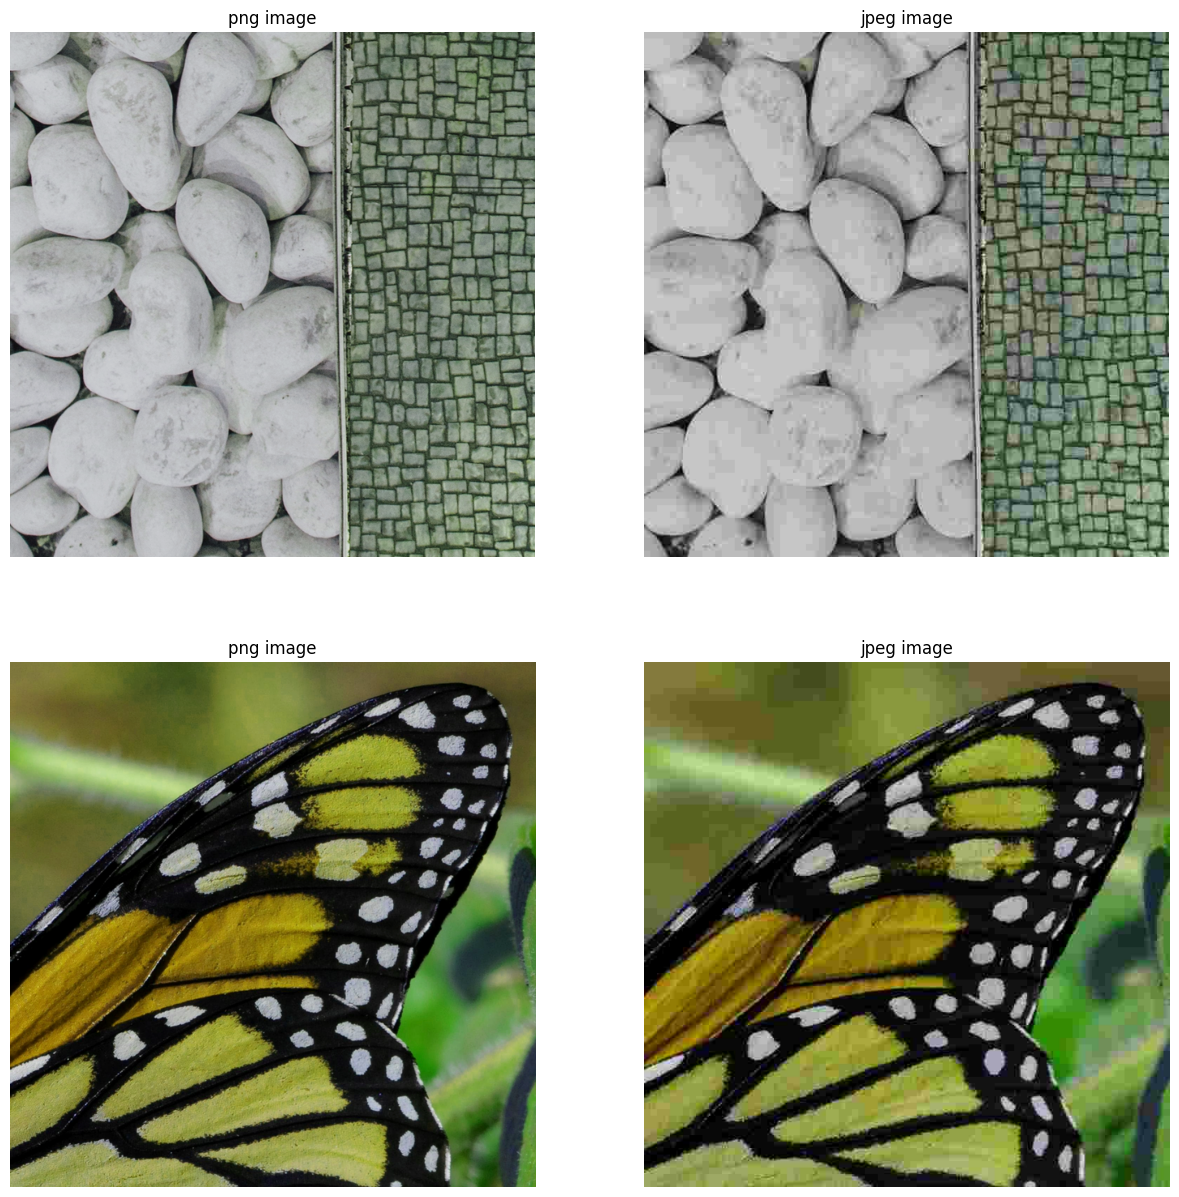

In [37]:

plt.figure(figsize=(15,15))

index = 1
for i in range(2):
  x,y = viz.next()
  plt.subplot(2,2,index)
  plt.imshow((y*255).astype(np.uint8))
  plt.axis('off')
  plt.title('png image')
  index+=1

  plt.subplot(2,2,index)
  plt.imshow((x*255).astype(np.uint8))
  plt.axis('off')
  plt.title('jpeg image')
  index+=1

plt.show()

## Model - Generator

<li>As we are following No Gan approach , initially generator is training first.</li>
<li> Here one residual in residual block is used, this block is referenced from the esrgan official paper


In [38]:


 def residual_dense_block(input, filters):
    x1 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input)
    x1 = LeakyReLU(0.2)(x1)
    x1 = Concatenate()([input, x1])

    x2 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x1)
    x2 = LeakyReLU(0.2)(x2)
    x2 = Concatenate()([input, x1, x2])

    x3 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x2)
    x3 = LeakyReLU(0.2)(x3)
    x3 = Concatenate()([input, x1, x2, x3])

    x4 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x3)
    x = Add()([x4, input])

    return x

def rrdb_net(input_shape=(None, None, 3), filters=64, scale_factor=4, name='RRDB_model'):
    lr_image = Input(shape=input_shape, name='input')

    x_start = Conv2D(filters, kernel_size=3, strides=1, padding='same')(lr_image)
    x_start = LeakyReLU(0.2)(x_start)

    x = residual_dense_block(x_start, filters)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    out = Conv2D(filters=3, kernel_size=3, activation='sigmoid',strides=1, padding='same')(x)

    return Model(inputs=lr_image, outputs=out, name=name)



In [32]:
generator = rrdb_net()

In [39]:
generator.summary()

Model: "RRDB_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   1792        ['input[0][0]']                  
                                64)                                                               
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, None, None,   0           ['conv2d_7[0][0]']               
                                64)                                                      

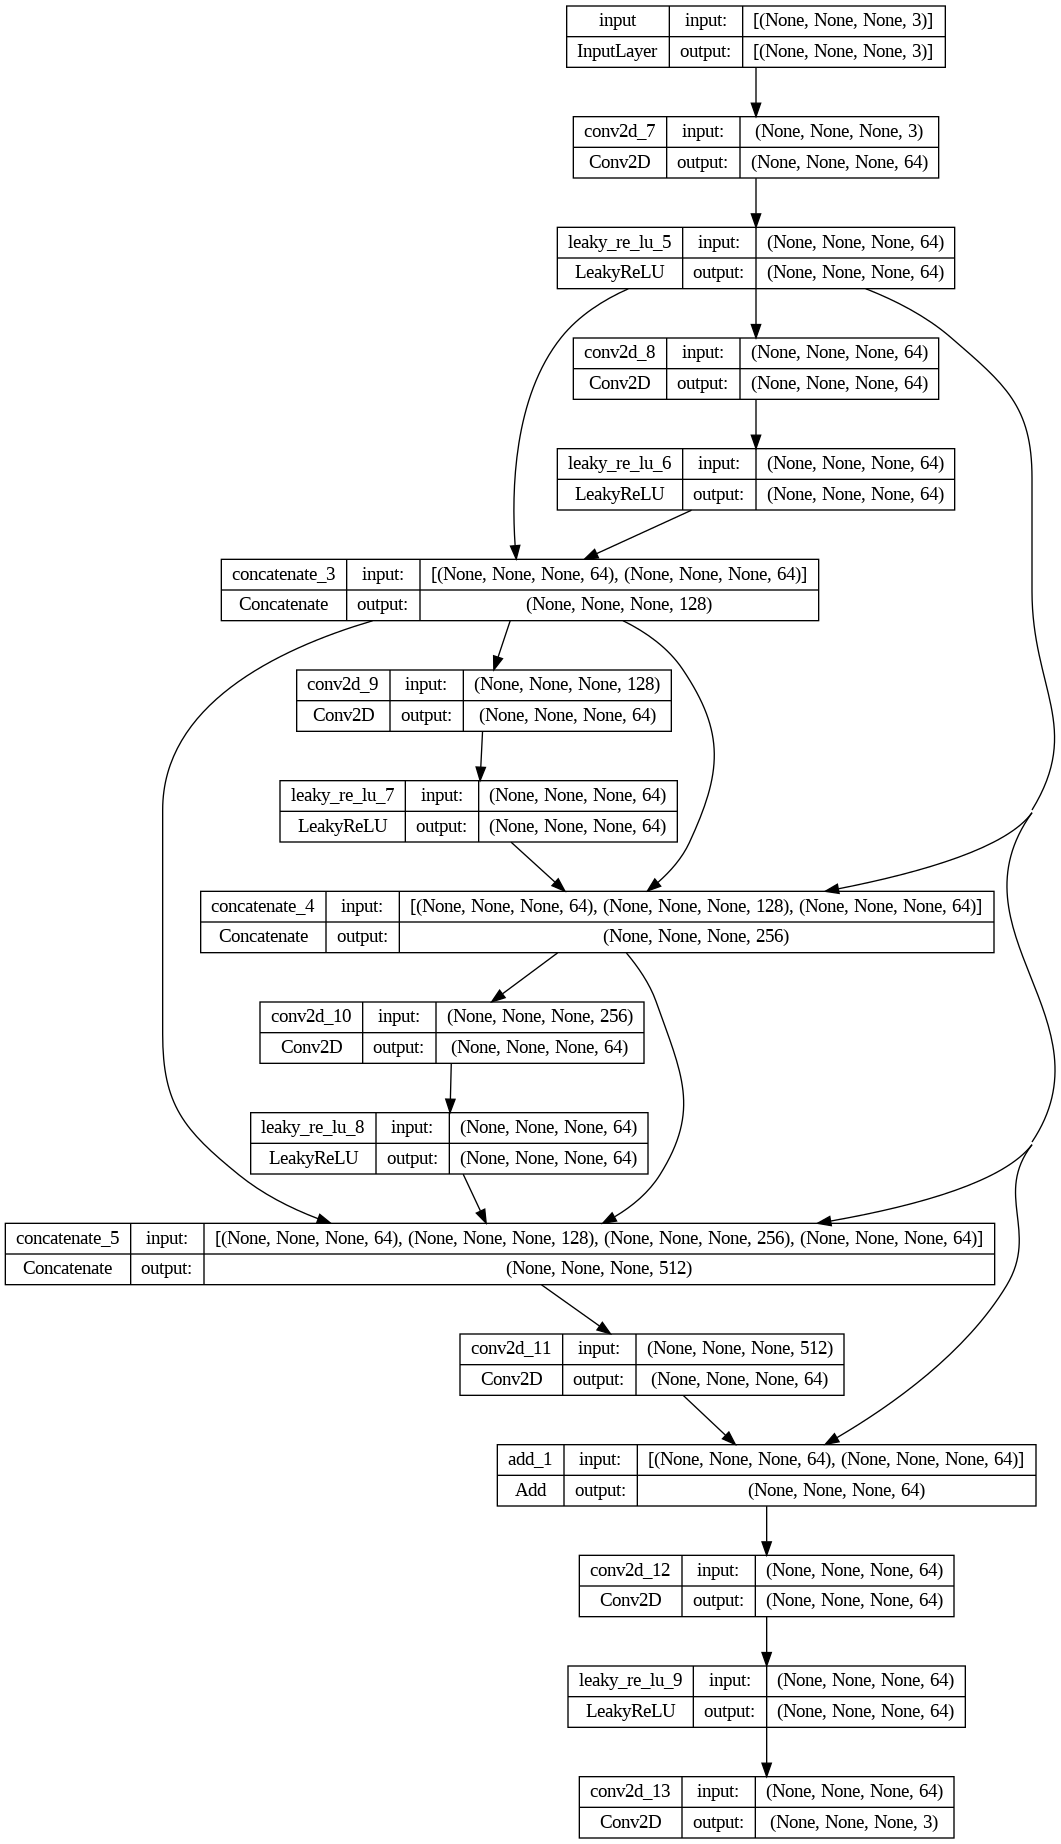

In [40]:
tf.keras.utils.plot_model(generator,'generator.png',show_shapes=True)

## Losses - Generator

<li> For the losses , here we are using perceptual loss , ie., the output from the generator and the truth png image is passed to the vgg network , Features of these two images are calculated and then MSE is calculated for these features.The main reason , i chose this loss because as compared to mse directly on the image, perceptual loss is more aligned with the human perception and provided better results.</li>


In [19]:
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19

In [20]:

def perceptual_loss():
  loss_func = tf.keras.losses.MeanSquaredError()
  vgg = VGG19(input_shape=(None, None, 3), include_top=False, weights='imagenet')
  fea_extrator = tf.keras.Model(vgg.input, vgg.layers[20].output)
  fea_extrator.trainable = False

  @tf.function
  def content_loss(real_hr, fake_hr):
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg featuremaps.
        preprocess_fake_hr = preprocess_input(fake_hr * 255.) / 12.75
        preprocess_real_hr = preprocess_input(real_hr * 255.) / 12.75
        fake_hr_features = fea_extrator(preprocess_fake_hr)
        real_hr_features = fea_extrator(preprocess_real_hr)

        return loss_func(real_hr_features, fake_hr_features)

  return content_loss

## Optimizers and Configuations

In [37]:







# # Learning rate scheduler

# # epoch = 5000
# # batch size = 35
# # steps = 20/epoch
# # for 5000 epochs= 100000steps
# boundary = [20000,50000,80000]

# lr_value = [ 1e-4]
# for i in range(3):
#   lr_value.append(lr_value[-1]*0.5)

# multi_step_lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[30000,50000,80000], values=lr_value)

## Training and Evaluation - Generator

In [41]:
# mean sqaured error
pixel_loss =  tf.keras.losses.MeanSquaredError()
feature_loss = perceptual_loss()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

@tf.function
def train_step(batch):
  x,y= batch
  with tf.GradientTape() as tape:
    # forward pass
    yhat = generator(x,training=True)
    # mse directly on the image
    mse = pixel_loss(y,yhat)
    # mse on the features
    content_loss = feature_loss(y,yhat)
    # total loss
    total_loss = mse+content_loss

  # back propagation, calculating the gradients of loss with  respect to the weights and biases
  grad= tape.gradient(total_loss,generator.trainable_variables)
  # updating the weights
  opt.apply_gradients(zip(grad,generator.trainable_variables))
  return total_loss

@tf.function
def test_step(batch):
  x,y = batch
  yhat = generator(x,training=False)
  loss = pixel_loss(y,yhat)
  # for validation we are calculating the structual similarity index vallue for figuring out the similarity of the
  # generated image and the referance image
  ssim = tf.image.ssim(y,yhat,max_val=1)
  return loss,ssim







In [ ]:
from tensorflow._api.v2 import train

# Creating Checkpoint for storing the model and optimizers state
checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                     optimizer=opt,
                                     model=generator)

# Checkpoint manager for managing the checkpoints, here we are only keeping the loss 3 checkpoints
manager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                         directory=config['gen_checkpoint_path'],
                                         max_to_keep=3)


# this step is crucial ,as we can continue training from the latest checkpoint.
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print('[*] load ckpt from {} at step {}.'.format(
            manager.latest_checkpoint, checkpoint.step.numpy()))
else:
    print("[*] training from scratch.")


for epoch in range(config['gen_epochs']):

  for batch in train_data:
    checkpoint.step.assign_add(1)
    train_loss = train_step(batch)
    print(checkpoint.step.numpy())

  t_ssim=0
  for batch in val_data:
      val_loss,ssim = test_step(batch)
      t_ssim+=ssim

  print(f'curr_step:{checkpoint.step.numpy()} train_loss:{train_loss}  val_loss:{val_loss} val_ssim:{t_ssim/100}')

  if((epoch+1)%10 == 0):
    manager.save()
    print(f'saved ckpt file{manager.latest_checkpoint}')

generator.save(config['gen_model_path'])

In [45]:
# loading the model from the saved model path
generator = tf.keras.models.load_model(config['gen_model_path'])

## Testing of generator

After the training of the generator , here we are testing the generator against the test_data

In [96]:
test = test_data.as_numpy_iterator()

(1, 648, 648, 3)


Text(0.5, 1.0, 'Reconstructed image')

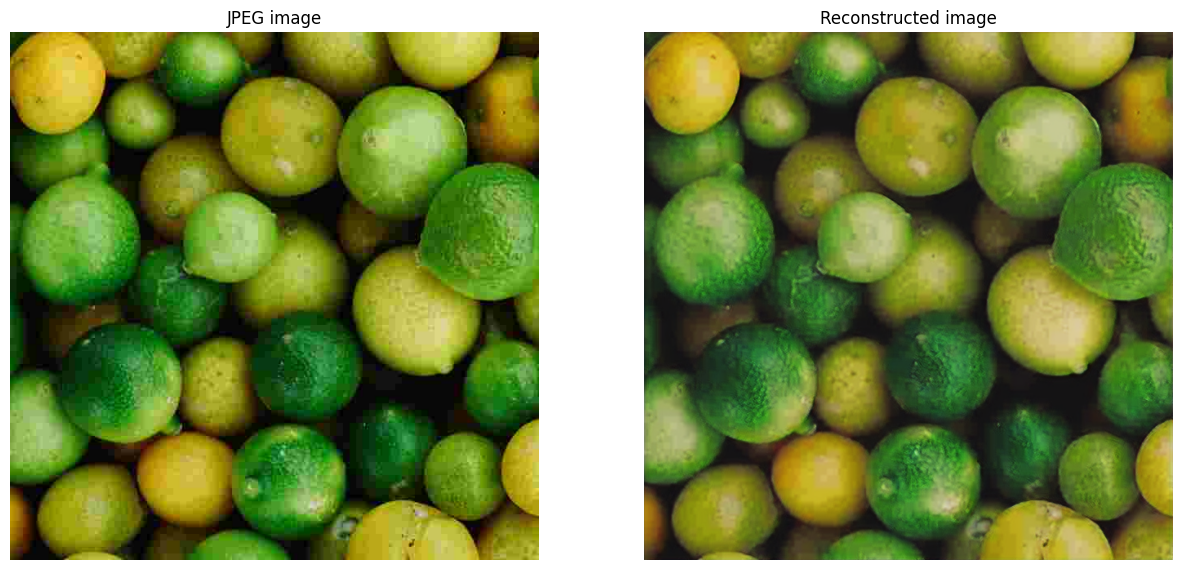

In [98]:
x = test.next()[0]

test_input=tf.expand_dims(x,axis=0)
test_output = generator(test_input)
print(test_output.shape)
test_output =tf.image.convert_image_dtype(test_output, dtype=tf.uint8)
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(tf.squeeze(test_input))
plt.axis('off')
plt.title('JPEG image')

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(test_output))
plt.axis('off')
plt.title('Reconstructed image')

# print(test_output.shape)


## Discriminator

<li> Creating the dataset, as for the discriminator , the input is reference image and the reconstructed image, we need to save the image generated by the trained generator</li>
<li> Forming the dataset for the Discriminator</li>
<li> train: 300 images(reference,reconstructed)</li>
<li> test: 50 images(reference,reconstructed)</li>
<li> val : 50 images(referance,reconstructed)</li>


In [ ]:
fakeinput = sorted([ image for image in os.listdir(config['in_data_path'])])
fakeinput = fakeinput[:-500]

In [ ]:

for image in fakeinput:
  fake = image.split('.')[0]+'.png'
  img = loadimage(os.path.join(config['in_data_path'],image))
  fakeoutput = generator(tf.expand_dims(img,axis=0))
  fakeoutput = tf.squeeze(tf.cast(fakeoutput*255,tf.uint8))
  save_img(os.path.join(config['fake_data_path'],fake),fakeoutput)

In [ ]:
disc_real = ref_dataset.take(400)
disc_fake = tf.data.Dataset.list_files(os.path.join(config['fake_data_path'],'*.png'),shuffle=False)
disc_fake = disc_fake.map(loadimage)
disc_data = tf.data.Dataset.zip((disc_fake,disc_real))

In [ ]:
disc_train_data = disc_data.take(300)
disc_train_data = disc_train_data.shuffle(300)
disc_train_data = disc_train_data.batch(1)
disc_train_data = disc_train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
disc_val_data = disc_data.skip(300).take(50)
disc_val_data = disc_val_data.shuffle(50)
disc_val_data = disc_val_data.batch(1)
disc_val_data = disc_val_data.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
disc_test_data = disc_data.skip(350).take(50)
disc_test_data = disc_test_data.shuffle(50)
disc_test_data = disc_test_data.batch(1)
disc_test_data = disc_test_data.prefetch(tf.data.experimental.AUTOTUNE)

## Model - Descriminator

Here i am using 6 convolution layer and LeakyRelu is used as activation function and for the last layer sigmoid is used as we are determining the binary classification of  fake or real for the input image

In [ ]:

def discriminator_model(filters=64):

    input = Input((None,None,3))
    x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(input)
    x = LeakyReLU(0.2)(input)
    x = Conv2D(filters*2, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters*2, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters*4, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters*4, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters*8, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(filters*16)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1,activation='sigmoid')(x)

    return Model(inputs=input,outputs=x,name='discriminator')


In [ ]:
disc = discriminator_model()

In [ ]:
disc.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 3)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 128)   3584      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, None, None, 128)   0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, None, None, 128)   0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 256) 

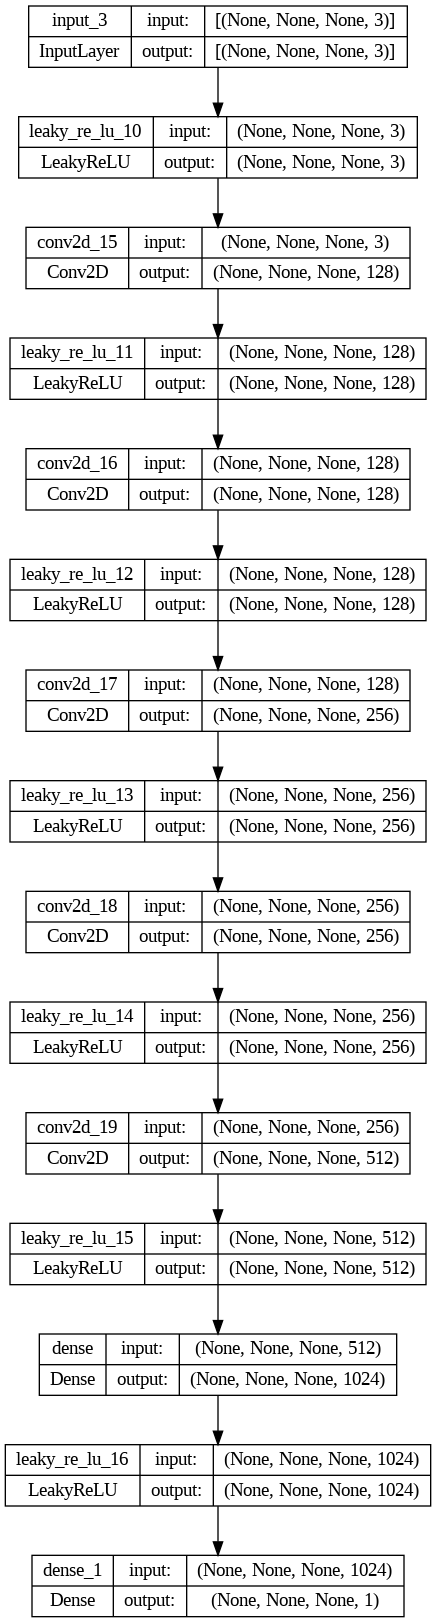

In [ ]:
tf.keras.utils.plot_model(disc,"discriminator.png",show_shapes=True)

## Training and Evaulation - Discriminator

<li>  Binary cross entropy is used a Loss function for both referance and reconstructed images</li>


In [55]:
class_loss = tf.keras.losses.BinaryCrossentropy()
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
r = tf.keras.metrics.Recall()
p = tf.keras.metrics.Precision()

@tf.function
def disc_train_step(batch):
    fake,real = batch
    with tf.GradientTape() as tape:
      fake,real = batch
      # forward pass
      yfake = disc(fake)
      yreal = disc(real)
      # loss for real and fake images
      realloss = class_loss(tf.ones_like(yreal),yreal)
      fakeloss = class_loss(tf.zeros_like(yfake),yfake)
      totalloss = realloss+fakeloss
    # calculating gradient of total loss wrt weights
    grad = tape.gradient(totalloss,disc.trainable_variables)
    # updating the weights and parameters
    disc_opt.apply_gradients(zip(grad,disc.trainable_variables))
    return totalloss

@tf.function
def disc_test_step(batch):
  fake,real = batch
  yfake = disc(fake)
  yreal = disc(real)
  realloss = class_loss(tf.ones_like(yreal),yreal)
  fakeloss = class_loss(tf.zeros_like(yfake),yfake)
  totalloss = realloss+fakeloss
  r.update_state(tf.zeros_like(yfake),yfake)
  p.update_state(tf.zeros_like(yfake),yfake)
  return totalloss





In [ ]:
# here the same step for the generator is followed , as checkpoints is saved for 10 epochs and incase of training is stopped , we can
# we can continue the training from  the saved checkpoints

disc_checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                     optimizer=disc_opt,
                                     model=disc)
disc_manager = tf.train.CheckpointManager(checkpoint=disc_checkpoint,
                                         directory=config['disc_checkpoint_path'],
                                         max_to_keep=3)

if disc_manager.latest_checkpoint:
    disc_checkpoint.restore(disc_manager.latest_checkpoint)
    print('[*] load ckpt from {} at step {}.'.format(
            disc_manager.latest_checkpoint, disc_checkpoint.step.numpy()))
else:
    print("[*] training from scratch.")

for epoch in range(config['disc_epochs']):

  for batch in train_data:
    disc_checkpoint.step.assign_add(1)
    train_loss = disc_train_step(batch)


  for batch in val_data:
      val_loss = disc_test_step(batch)

  print(f'curr_step:{disc_checkpoint.step.numpy()} train_loss:{train_loss}  val_loss:{val_loss} val_recall:{r.result().numpy()} val_precision:{p.result().numpy()}')
  r.reset_state()
  p.reset_state()
  if((epoch+1)%10 == 0):
    disc_manager.save()
    print(f'saved ckpt file{disc_manager.latest_checkpoint}')


disc.save(config['disc_model_path'])


In [ ]:
disc.save(config['disc_model_path'])


## GAN TRAINING

<li> Traditional Gan training is followed combining both generator and discriminator</li>
<li> Here for generator, in addition the perceptual loss , binary cross entropy  loss is also calculated as generator want the generated images to be classified as real</li>
<li> For the validation, PSNR(peak-signal to Noise ratio) and SSIM(structural similarity index) is calculated to measure the similarity of the generated images</li>

In [22]:
generator = tf.keras.models.load_model(config['gan_gen_model_path'])
disc = tf.keras.models.load_model(config['gan_disc_model_path'])
opt = tf.keras.optimizers.Adam(learning_rate=0.0000000001)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0000000001)
class_loss = tf.keras.losses.BinaryCrossentropy()
feature_loss = perceptual_loss()
pixel_loss = tf.keras.losses.MeanSquaredError()
def genloss(png,reconst):
    mse = pixel_loss(png,reconst)
    content_loss = feature_loss(png,reconst)
    total_loss = mse+content_loss
    return total_loss

def discloss(real,fake):
    realloss = class_loss(tf.ones_like(real),real)
    fakeloss = class_loss(tf.zeros_like(fake),fake)
    return realloss+fakeloss


@tf.function
def gan_train_step(batch):
  jpeg,png = batch

  with tf.GradientTape(persistent=True)as tape:
    # forward pass
    reconst= generator(jpeg)
    real = disc(png)
    fake = disc(reconst)

    # loss calculation
    g_loss = class_loss(tf.ones_like(fake),fake)+genloss(png,reconst)
    d_loss = discloss(real,fake)

  # calculation of gradients and updation of weights
  g_grad = tape.gradient(g_loss,generator.trainable_variables)
  d_grad = tape.gradient(d_loss,disc.trainable_variables)
  opt.apply_gradients(zip(g_grad,generator.trainable_variables))
  disc_opt.apply_gradients(zip(d_grad,disc.trainable_variables))

  return (g_loss,d_loss)



@tf.function
def gan_test_step(batch):
  jpeg,png = batch
  with tf.GradientTape(persistent=True)as tape:
    reconst= generator(jpeg)
    real = disc(png)
    fake = disc(reconst)
    g_loss = class_loss(tf.ones_like(fake),fake)+genloss(png,reconst)
    d_loss = discloss(real,fake)

  ssim = tf.image.ssim(png,reconst,max_val=1)
  psnr = tf.image.psnr(png,reconst,max_val=1)

  return (g_loss,d_loss,ssim,psnr)

In [ ]:

gan_checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                     optimizer_g=opt,
                                     optimizer_d=disc_opt,
                                     model = generator,
                                     discriminator= disc)

gan_manager = tf.train.CheckpointManager(checkpoint=gan_checkpoint,
                                         directory=config['gan_checkpoint_path'],
                                         max_to_keep=3)

if gan_manager.latest_checkpoint:
      gan_checkpoint.restore(gan_manager.latest_checkpoint)
      print('[*] load ckpt from {} at step {}.'.format(
            gan_manager.latest_checkpoint, gan_checkpoint.step.numpy()))
else:
      print("[*] training from scratch")


for epoch in range(config['gan_epochs']):
  for batch in train_data:
    gan_checkpoint.step.assign_add(1)
    train_g_loss,train_d_loss = gan_train_step(batch)

  t_ssim=0
  t_psnr=0
  for batch in val_data:
    (val_g_loss,val_d_loss,ssim,psnr)= gan_test_step(batch)
    t_ssim+=ssim
    t_psnr+=psnr

  print(f'curr_step: {gan_checkpoint.step.numpy()} train_gen_loss: {train_g_loss} train_disc_loss:{train_d_loss} val_gen_loss: {val_g_loss}\
          val_disc_loss: {val_d_loss} ssim: {t_ssim/100} psnr: {t_psnr/100}')

  if((epoch+1)%10 == 0):
    gan_manager.save()
    print(f'saved ckpt file{gan_manager.latest_checkpoint}')


generator.save(config['gan_gen_model_path'])
disc.save(config['gan_disc_model_path'])

In [ ]:
generator.save(config['gan_gen_model_path'])
disc.save(config['gan_disc_model_path'])\
# saving both the generator and discriminator and loading the generator model for further testing
gan_generator = tf.keras.models.load_model(config['gan_gen_model_path'])

# Testing of the Final Generator Model

<li> After the convergence of the generator model, we are tesiting the model against the test images

In [121]:
t_psnr = 0
t_ssim = 0
for image in test_data:
  input = image[0]
  truth = image[1]
  input = tf.expand_dims(input,axis=0)
  reconst = gan_generator(input)
  reconst = tf.squeeze(reconst,axis=0)
  psnr = tf.image.psnr(truth,reconst,max_val=1)
  ssim = tf.image.ssim(truth,reconst,max_val=1)
  t_psnr+=psnr
  t_ssim+=ssim


print(f'Average PSNR : {t_psnr/100.0} and SSIM : {t_ssim/100.0} for the reconstructed iamge in the test data')

Average PSNR : 22.081161499023438 and SSIM : 0.7332820892333984 for the reconstructed iamge in the test data


In [ ]:
val_data.as_numpy_itear

In [122]:
test = test_data.as_numpy_iterator()

In [ ]:
img= test.next()
jpeg= img[0]

png = img[1]
jpeg=tf.expand_dims(jpeg,axis=0)

# inference
reconst = gan_generator(jpeg)
reconst = tf.image.convert_image_dtype(reconst, dtype=tf.uint8)
png= tf.cast(png*255,tf.uint8)
jpeg =tf.cast(jpeg*255,tf.uint8)

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(tf.squeeze(jpeg))
plt.axis('off')
plt.title('JPEG image')

plt.subplot(1,3,2)
plt.imshow(tf.squeeze(reconst))
plt.axis('off')
plt.title('Reconstructed image')

plt.subplot(1,3,3)
plt.imshow(png)
plt.axis('off')
plt.title('PNG image')

# print(test_output.shape)

## Testing of Upscale pics

In [118]:

upscaleinput = sorted([image for image in os.listdir(config['upscaleinput'])])
print(upscaleinput)

['test_image_1.png', 'test_image_2.png', 'test_image_3.png', 'test_image_4.png', 'test_image_5.png', 'test_image_6.png']


In [ ]:
u_input = []
u_output = []

for image in upscaleinput:
  input = loadimage(os.path.join(config['upscaleinput'],image))
  input = input[:,:,:3]
  output = gan_generator(tf.expand_dims(input,axis=0))
  output =tf.squeeze(tf.image.convert_image_dtype(output, dtype=tf.float32))
  u_input.append(input)
  u_output.append(output)
  save_img(os.path.join(config['upscaleoutput'],image),output)




# visualization of upscale test pics

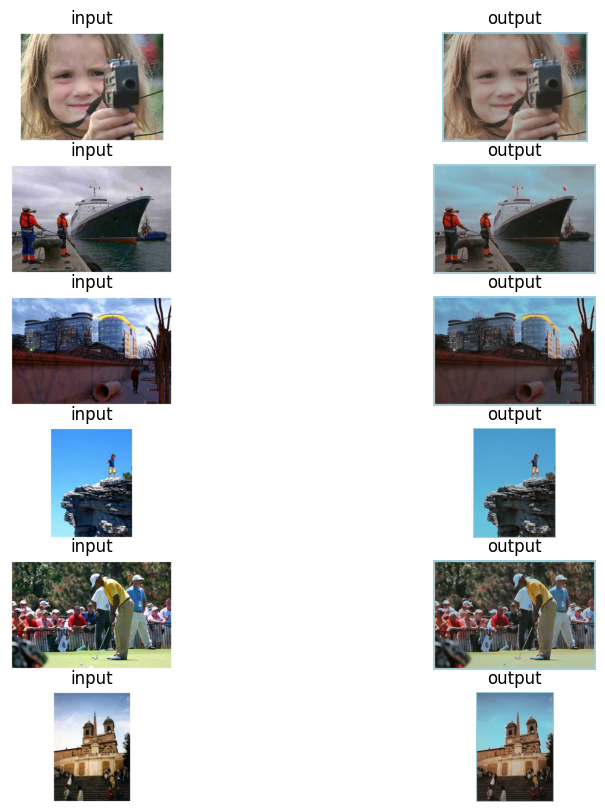

In [29]:

plt.figure(figsize=(10,10))
count = 1
for i in range(len(u_input)):
  plt.subplot(6,2,count)
  plt.imshow(u_input[i])
  plt.axis('off')
  plt.title('input')
  count+=1

  plt.subplot(6,2,count)
  plt.imshow(u_output[i])
  plt.axis('off')
  plt.title('output')
  count+=1
